# ASX rate tracker

Note: Data prior to 12 April sourced from Matt Cowgil's github site:
https://github.com/MattCowgill/cash-rate-scraper.git

## Python set-up

In [1]:
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotting as pg

In [2]:
# save charts in this notebook
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/ASX/"
pg.set_chart_dir(CHART_DIR)
pg.clear_chart_dir(CHART_DIR)

RFOOTER = 'Source: ASX'
LFOOTER = 'Australia. '
FOOTERS = {'lfooter': LFOOTER, 'rfooter': RFOOTER}

# True to see the charts in the notebook
SHOW=True

## Data aggregation

In [19]:
def aggregate_data() -> pd.DataFrame:

    # Find files 
    directory = "./ASX_DAILY_DATA/"
    file_stem = 'scraped_cash_rate_'
    pattern = f"{directory}{file_stem}*.csv"
    files = glob.glob(pattern)

    # Read each file into a dataframe and put it in the dictionary
    dict_of_series = {}
    ignored_dates = []
    for file in files:
        day_data = pd.read_csv(file, index_col=0) 
        scraped_date = day_data['scrape_date'].iloc[0]
        cash_rate_day = day_data['cash_rate']
        if cash_rate_day.isnull().any():
            # drop the date if there are any missing values
            ignored_dates.append(scraped_date)
            continue
        cash_rate_day.index = pd.PeriodIndex(cash_rate_day.index, freq='M')
        dict_of_series[scraped_date] = cash_rate_day


    # report dropped dates
    print(f"Dates ignored: {' '.join(sorted(ignored_dates))}")

    # Create a new dataframe and return it
    combined_df = (
        pd.DataFrame(dict_of_series)
        .T
        .sort_index(ascending=True)
        .sort_index(ascending=True, axis=1)
    )
    combined_df.index = pd.PeriodIndex(combined_df.index, freq='D')

    # drop saturday/sunday data
    combined_df = combined_df[~combined_df.index.dayofweek.isin([5, 6])]

    # drop data with implausible odd starts
    dataset = combined_df.T
    lose = []
    for col in dataset:
        na_data = dataset[col].dropna()
        if (na_data.iloc[0] >= na_data.iloc[1] + 1):
            lose.append(col)
    print(f"Dates with odd starts (dropped): {lose}")
    combined_df = combined_df.drop(lose)
    
    return combined_df


df = aggregate_data()

Dates ignored: 2022-07-21 2022-07-22 2022-08-23 2022-08-25 2022-08-26 2023-01-18
Noise: 2022-05-03    3.280
2022-06-24    3.290
2022-04-29    3.305
2022-05-02    3.310
2022-04-28    3.325
2022-05-09    3.340
2022-05-10    3.345
2022-04-27    3.375
2022-05-04    3.395
2022-06-23    3.400
2022-05-06    3.445
2022-04-26    3.455
2022-06-22    3.530
2022-06-15    3.540
2022-05-05    3.650
2022-06-17    3.675
2022-06-21    3.705
2022-06-20    3.755
2022-06-16    3.790
2022-08-08    4.085
Freq: D, dtype: float64
Dates with implausible starts: [Period('2022-08-08', 'D')]


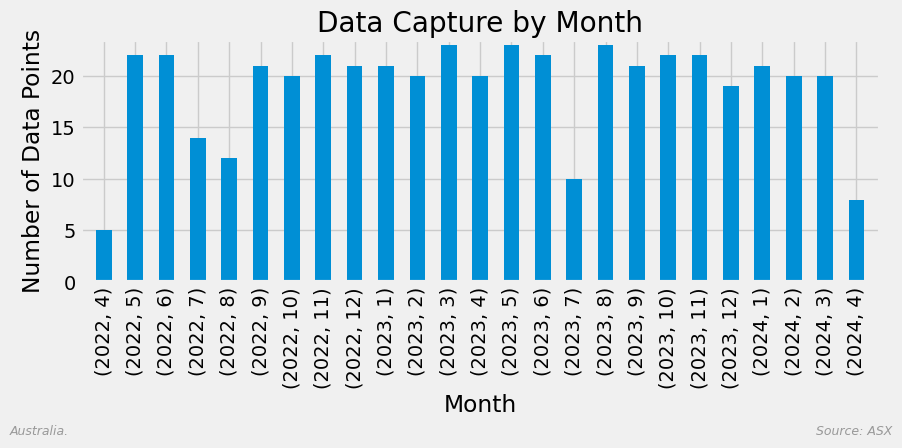

In [4]:
def data_capture_by_month():
    ax = df.groupby([df.index.year, df.index.month]).agg({'count'}).max(axis=1).plot.bar()
    pg.finalise_plot(
        ax, 
        title='Data Capture by Month', 
        xlabel='Month',
        ylabel='Number of Data Points',
        **FOOTERS,
        show=True)



data_capture_by_month()

## Plot

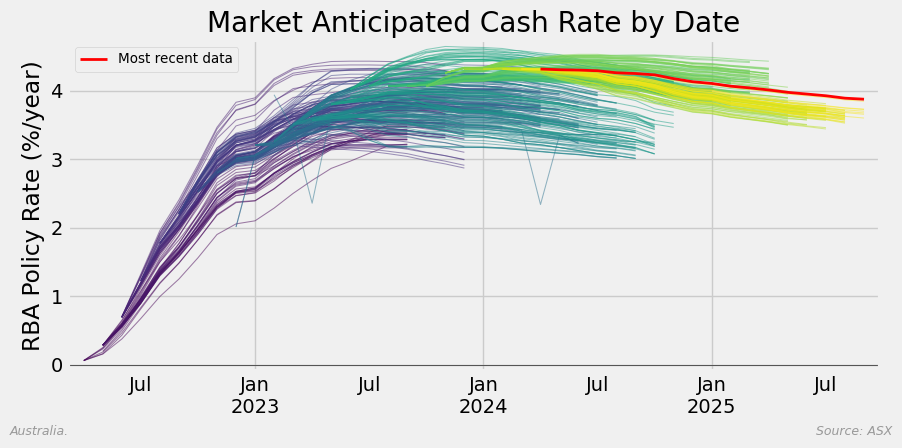

In [18]:
import seaborn as sns
data = df.T.copy()
columns = [f"_{x}" for x in data.columns]
data.columns = columns
num_columns = len(data.columns)
colors = sns.color_palette("viridis", num_columns)
ax = data.plot(color=colors, lw=0.75, alpha=0.5)
columns[-1] = columns[-1].replace('_', '')
data.columns = columns
ax = data[data.columns[-1]].plot(color='red', lw=2, label='Most recent data')

pg.finalise_plot(
    ax, 
    title='Market Anticipated Cash Rate by Date', 
    ylabel='RBA Policy Rate (%/year)',
    y0=True,
    zero_y=True,
    **FOOTERS,
    legend={'loc': 'best', 'fontsize': 'x-small'},
    show=True,
)